In [23]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy
import pandas as pd

# Set DeepXDE backend, we could use tensorflow, jax or paddle instead
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Increasing floating point precision
dde.config.set_default_float('float64')

# For experiments reproductibility
dde.config.set_random_seed(42)

Set the default float type to float64


## SIR Model

$$
\frac{dS}{dt} = −βSI
$$
$$
\frac{dI}{dt} = βSI − γI
$$
$$
\frac{dR}{dt} = γI.
$$


In [44]:

df = pd.read_csv("../data/covid-es.csv", encoding="latin-1", sep=",")

# Discarding non recovery/death outcomes
df = df[df["Evolucao"].isin(["Cura", "Óbito pelo COVID-19"])]

# Translating column names
df["NotificationDate"] = df["DataNotificacao"]
df["DeathDate"] = df["DataObito"]
df["RecoveryDate"] = df.apply(lambda row: row["DataEncerramento"] if row["Evolucao"] == "Cura" else None, axis=1)

# Converting to datetime
df["NotificationDate"] = pd.to_datetime(df["NotificationDate"], format='%Y-%m-%d')
df["DeathDate"] = pd.to_datetime(df["DeathDate"], format='%Y-%m-%d')
df["RecoveryDate"] = pd.to_datetime(df["RecoveryDate"], format='%Y-%m-%d')

# Discarding inconsistent entries
df = df[df["RecoveryDate"] >= df["NotificationDate"]]


In [50]:

date_range = pd.date_range(
    start=df['NotificationDate'].min(),
    end=max(df['RecoveryDate'].max(), df['DeathDate'].max()),
    freq='D'
)

# Initialize SIR DataFrame
sir = pd.DataFrame(index=date_range, columns=['S', 'I', 'R'])

pd.set_option('future.no_silent_downcasting', True)
sir = sir.fillna(0)

# Track daily active and removed cases
for i, row in df.iterrows():
    
    # Active from notification until recovery/death
    start = row['NotificationDate']
    end = row['RecoveryDate'] if pd.notna(row['RecoveryDate']) else row['DeathDate']
    
    if pd.isna(end):  # Case is still active (no recovery/death)
        sir.loc[start:, 'I'] += 1
    else:  # Case becomes removed on recovery/death date
        assert start <= end, f"Inconsistency at row {i}, start={start}, end={end}, death={row["DeathDate"]}, rec={row["RecoveryDate"]}"
        sir.loc[start:end - pd.Timedelta(days=1), 'I'] += 1
        sir.loc[end:, 'R'] += 1

TOTAL_POPULATION = 3833712  # 2022 Census
sir['S'] = TOTAL_POPULATION - sir['I'] - sir['R']


In [52]:
sir.head()

,S,I,R
2020-02-29,3833711,1,0
2020-03-01,3833711,1,0
2020-03-02,3833711,1,0
2020-03-03,3833711,1,0
2020-03-04,3833711,1,0


In [53]:
# Normalization

S_data = sir["S"].astype(float).values / TOTAL_POPULATION
I_data = sir["I"].astype(float).values / TOTAL_POPULATION
R_data = sir["R"].astype(float).values / TOTAL_POPULATION

In [54]:
# Parameters
t0, tf = 0, sir.shape[0]

S0 = S_data[0]
I0 = I_data[0]
R0 = R_data[0]

In [55]:
# Leranable external parameters
beta = dde.Variable(0.5)
gamma = dde.Variable(0.5)

In [57]:
# Solving the model

def sir_model(t, y):

    S, I, R = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    dS_dt = dde.grad.jacobian(y, t, i=0)
    dI_dt = dde.grad.jacobian(y, t, i=1)
    dR_dt = dde.grad.jacobian(y, t, i=2)
    
    return [
        dS_dt - (-beta * S * I),
        dI_dt - (beta * S * I - gamma * I),
        dR_dt - (gamma * I)   
    ]


t_data = np.arange(t0, tf).reshape(-1, 1)

observed_data = np.hstack([t_data, S_data.reshape(-1, 1), I_data.reshape(-1, 1), R_data.reshape(-1, 1)])


geom = dde.geometry.TimeDomain(t0, tf)

observe_t = t_data
observe_y = np.hstack([S_data.reshape(-1, 1), I_data.reshape(-1, 1), R_data.reshape(-1, 1)], dtype="float64")

bc_S = dde.icbc.PointSetBC(observe_t, observe_y[:, 0:1], component=0)  # S
bc_I = dde.icbc.PointSetBC(observe_t, observe_y[:, 1:2], component=1)  # I
bc_R = dde.icbc.PointSetBC(observe_t, observe_y[:, 2:3], component=2)  # R

ic_S = dde.icbc.IC(geom, lambda _: S0, lambda _, on_initial: on_initial, component=0)
ic_I = dde.icbc.IC(geom, lambda _: I0, lambda _, on_initial: on_initial, component=1)
ic_R = dde.icbc.IC(geom, lambda _: R0, lambda _, on_initial: on_initial, component=2)

data = dde.data.PDE(
    geom, 
    sir_model, 
    [bc_S, bc_I, bc_R, ic_S, ic_I, ic_R],
    num_domain=100, 
    num_boundary=2,
    anchors=observe_t)

net = dde.nn.FNN([1] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=0.001,  external_trainable_variables=[beta, gamma])

variable_cb = dde.callbacks.VariableValue([beta, gamma], period=1000, filename="../variables/sir-beta-gamma.dat")


Compiling model...
'compile' took 0.000174 s



Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.79e-01, 4.38e-01, 5.77e-02, 7.22e+00, 2.29e-01, 2.81e-01, 1.00e+00, 6.80e-14, 0.00e+00]    [1.79e-01, 4.38e-01, 5.77e-02, 7.22e+00, 2.29e-01, 2.81e-01, 1.00e+00, 6.80e-14, 0.00e+00]    []  
1000      [4.84e-06, 4.09e-07, 3.70e-07, 1.13e-05, 1.93e-06, 8.89e-06, 6.48e-10, 7.64e-10, 8.16e-13]    [4.84e-06, 4.09e-07, 3.70e-07, 1.13e-05, 1.93e-06, 8.89e-06, 6.48e-10, 7.64e-10, 8.16e-13]    []  
2000      [3.30e-06, 2.73e-07, 3.89e-07, 1.05e-05, 1.62e-06, 7.70e-06, 5.58e-10, 5.00e-10, 4.38e-13]    [3.30e-06, 2.73e-07, 3.89e-07, 1.05e-05, 1.62e-06, 7.70e-06, 5.58e-10, 5.00e-10, 4.38e-13]    []  
3000      [2.48e-06, 8.30e-08, 5.31e-07, 1.04e-05, 1.43e-06, 8.57e-06, 2.92e-10, 2.79e-12, 2.80e-09]    [2.48e-06, 8.30e-08, 5.31e-07, 1.04e-05, 1.43e-06, 8.57e-0

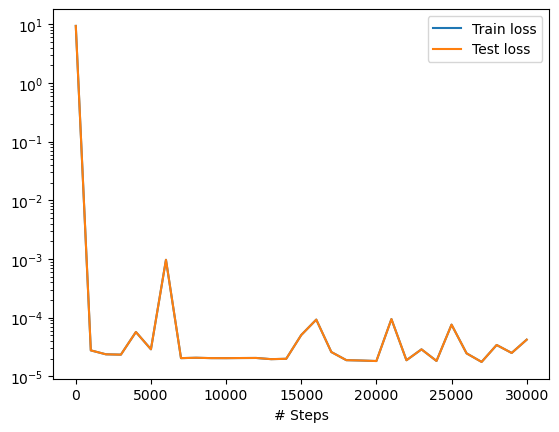

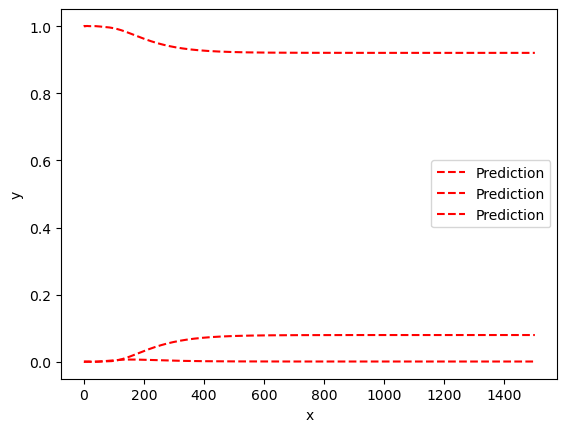

In [58]:

losshistory, train_state = model.train(iterations=30000, callbacks=[variable_cb], model_save_path="../models/inverse-sir-2")

dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [62]:
beta_pred = beta.detach().cpu().numpy()
gamma_pred = gamma.detach().cpu().numpy()

print(f"Learned parameters: beta = {beta_pred:.4f}, gamma = {gamma_pred:.4f}")


Learned parameters: beta = 0.0350, gamma = 0.0333


In [63]:

model.restore("../models/inverse-sir-2-30000.pt")

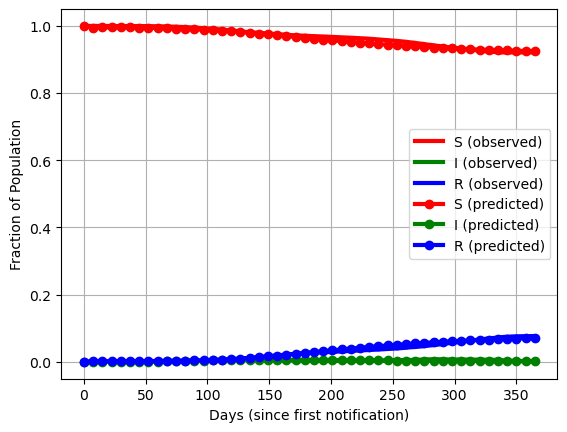

In [75]:
# Visualing results

nop = 50
time0, timef = 0, 365

t_test = np.linspace(time0, timef, nop).reshape(-1, 1)
y_pred = model.predict(t_test)
S_pred, I_pred, R_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

# plt.figure(figsize=(10, 6))

t_obs, S_obs, I_obs, R_obs = t_data[:timef], S_data[:timef], I_data[:timef], R_data[:timef]

plt.plot(t_obs, S_obs, "r-", label="S (observed)", linewidth=3)
plt.plot(t_obs, I_obs, "g-", label="I (observed)", linewidth=3)
plt.plot(t_obs, R_obs, "b-", label="R (observed)", linewidth=3)

plt.plot(t_test, S_pred, "ro-", label="S (predicted)", linewidth=3)
plt.plot(t_test, I_pred, "go-", label="I (predicted)", linewidth=3)
plt.plot(t_test, R_pred, "bo-", label="R (predicted)", linewidth=3)

plt.xlabel("Days (since first notification)")
plt.ylabel("Fraction of Population")
plt.legend()
plt.grid()
plt.savefig("../figures/inverse-sir-2.pdf")
plt.show()

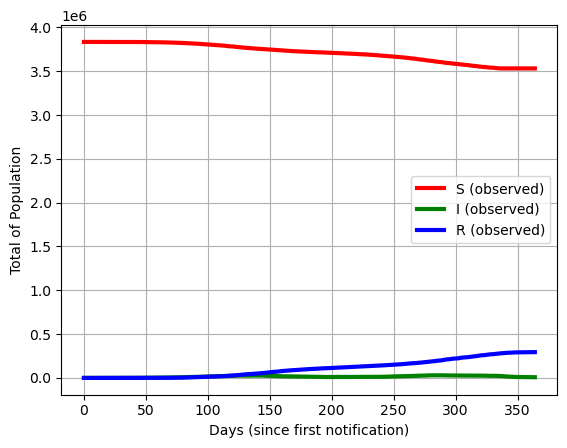

In [76]:

S_raw = sir["S"].astype(int).values
I_raw = sir["I"].astype(int).values
R_raw = sir["R"].astype(int).values

S_raw_obs, I_raw_obs, R_raw_obs = S_raw[:timef], I_raw[:timef], R_raw[:timef]

# plt.figure(figsize=(10, 6))

plt.plot(t_obs, S_raw_obs, "r-", label="S (observed)", linewidth=3)
plt.plot(t_obs, I_raw_obs, "g-", label="I (observed)", linewidth=3)
plt.plot(t_obs, R_raw_obs, "b-", label="R (observed)", linewidth=3)

plt.xlabel("Days (since first notification)")
plt.ylabel("Total of Population")
plt.legend()
plt.grid()
plt.savefig("../figures/inverse-sir-raw.pdf")
plt.show()